In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import scanpy as sc
import scvi
import sc_utils
#import scrublet as scr
warnings.filterwarnings('ignore')

Matplotlib is building the font cache; this may take a moment.


In [ ]:
import torch

In [ ]:
torch.cuda.device_count()

In [2]:
def get_markers(adata,groupby,key="rank_genes_groups",p_val_cutoff=0.05,logfc_cutoff=0.5):
    """\
    Extract markers from adata into Seurat-like table
    Extracts markers after they are computed by ``scanpy``. Produces Seurat-like
    table with fields
    ``"p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"``
    Calculates the percentage of cells that express a given gene
    in the target cluster (``pct.1`` field) and outside the cluster
    (``pct.2`` field) from ``adata.raw`` matrix.
    Parameters
    ----------
    adata
        Annotated data matrix.
    groupby
        ``adata.obs`` field used for marker calculation
    key
        ``adata.uns`` key that has computed markers
    p_val_cutoff
        Drop all genes with adjusted p-value greater than or equal to this
    logfc_cutoff
        Drop all genes with average logFC less than or equal to this
    Returns
    -------
    Returns a pandas dataframe with above listed columns, optionally
    subsetted on the genes that pass the cutoffs.
    ``p_val`` field is a copy of adjusted p-value field.
    Example
    -------
    >>> sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon", n_genes=200)
    >>> markers = sc_utils.get_markers(adata, "leiden")
    >>> markers.to_csv("markers.csv")
    """
    markers = pd.concat([
        pd.DataFrame(adata.uns[key]["names"]).melt(),
        pd.DataFrame(adata.uns[key]["pvals_adj"]).melt(),
        pd.DataFrame(adata.uns[key]["logfoldchanges"]).melt()
    ], axis=1)
    markers.columns = ("cluster", "gene", "cluster2", "p_val_adj", "cluster3", "avg_logFC")
    markers = markers.loc[:, ["cluster", "gene", "avg_logFC", "p_val_adj"]]
    markers = markers.loc[markers.avg_logFC > logfc_cutoff, ]
    markers = markers.loc[markers.p_val_adj < p_val_cutoff, ]
    markers["pct.1"] = pd.Series(dtype=float)
    markers["pct.2"] = pd.Series(dtype=float)
    for cluster in markers.cluster.unique():
        cells = adata.obs[groupby] == cluster
        in_cluster_selector = markers.cluster == cluster
        genes = markers.gene[in_cluster_selector]
        in_cluster = np.sum(adata.raw[cells, genes].X > 0, axis=0) / cells.sum()
        markers.loc[in_cluster_selector, "pct.1"] = in_cluster.T.A1
        other_cells = adata.obs[groupby] != cluster
        other_clusters = np.sum(adata.raw[other_cells, genes].X > 0, axis=0) / other_cells.sum()
        markers.loc[in_cluster_selector, "pct.2"] = other_clusters.T.A1
    markers["p_val"] = markers.p_val_adj
    markers = markers.loc[:, ["p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"]]
    return markers
    
# cr_dir = '/projects/b1038/Pulmonary/sfenske/sequencing/data/2024-4/cellranger'
# adata_sets = []
# for s in os.listdir(cr_dir):
#     if not s.endswith('.csv'):
#         sample_adata = sc.read_10x_h5(
#             f'{cr_dir}/{s}/outs/filtered_feature_bc_matrix.h5')
#         sample_adata.var_names_make_unique()
#         sample_adata.obs['sample_id'] = s
#         sample_adata.var['MT'] = sample_adata.var_names.str.startswith('MT-')
#         sample_adata.var['ribo'] = sample_adata.var_names.str.startswith(('RPS','RPL'))
#         try:
#             scrub = scr.Scrublet(sample_adata.X)
#             doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=True)
#             sample_adata.obs['doublet_scores'] = doublet_scores
#             sample_adata.obs['predicted_doublets'] = predicted_doublets
#         except:
#             print(f"error for {s}",flush=True)
#             sample_adata.obs['doublet_scores'] = 0
#             sample_adata.obs['predicted_doublets'] = False
#         adata_sets.append(sample_adata)
# adata = adata_sets[0].concatenate(adata_sets[1:],join='outer')

# adata.var.index = [x.split('GRCh38______')[1] if 'GRCh38______' in x else x for x in adata.var.index]
# adata.var.gene_ids = [x.split('GRCh38______')[1] if 'GRCh38______' in x else x for x in adata.var.gene_ids]
# adata.var['ensembl_id'] = adata.var['gene_ids']
# adata.var['gene_ids'] = adata.var.index
# adata.var['MT'] = adata.var_names.str.startswith('MT-')
# adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))
# sc.pp.calculate_qc_metrics(adata,qc_vars=['MT','ribo'],percent_top=[10,20],log1p=False,inplace=True)

# # for scArches
# adata.obs['sample'] = adata.obs['sample_id']

    
adata = sc.read_h5ad('../data/10x_PBMC.h5ad')

FOLDER = '../data/PBMC_9_4_2024'
OBJ_NAME = 'PBMC_integrated'
BATCH_VARIABLE = 'library_id'

adata.layers['counts'] = adata.X
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

sc.pp.highly_variable_genes(adata,subset=True,n_top_genes=2000,batch_key=BATCH_VARIABLE,flavor='seurat_v3',layer='counts')

param_set = {"n_layers":2,"n_hidden":256,"dropout_rate":0.2,"n_latent":10}
scvi.model.SCVI.setup_anndata(adata,layer="counts",batch_key=BATCH_VARIABLE)
# vae = scvi.model.SCVI.load(f"../DeepSeq_1113_vae_2000", adata)

vae = scvi.model.SCVI(adata,**param_set)

train_kwargs = {
    "early_stopping": True,
    "early_stopping_monitor": "reconstruction_loss_validation",
    "early_stopping_patience": 25
}
vae.train(max_epochs=400,**train_kwargs)
vae.save(f"../code/{OBJ_NAME}",overwrite=True)


latent_adata = vae.get_latent_representation()
adata.obsm["X_scVI"] = latent_adata
adata.layers["scvi_normalized"] = vae.get_normalized_expression(library_size=10e4)
sc.pp.neighbors(adata,use_rep='X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata,key_added="leiden_scVI")

adata.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(adata, "leiden_scVI", method="wilcoxon", n_genes=200)
markers = get_markers(adata,'leiden_scVI')

for col in adata.obs.columns:
    if adata.obs[col].dtype == 'category':
        adata.obs[col] = adata.obs[col].astype('str')


if not os.path.isdir(FOLDER):
    os.mkdir(FOLDER)
markers.to_csv(f'{FOLDER}/{OBJ_NAME}-markers.csv')
adata.obs.to_csv(f'{FOLDER}/{OBJ_NAME}-metadata.csv')
adata.write_h5ad(f'{FOLDER}/{OBJ_NAME}.h5ad')


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 119/400:  30%|██▉       | 119/400 [20:48<49:08, 10.49s/it, v_num=1, train_loss_step=310, train_loss_epoch=310]
Monitored metric reconstruction_loss_validation did not improve in the last 25 records. Best score: 306.893. Signaling Trainer to stop.


In [3]:
adata


AnnData object with n_obs × n_vars = 29976 × 2000
    obs: 'library_id', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'total_counts_MT', 'pct_counts_MT', 'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels', 'leiden_scVI'
    var: 'gene_ids', 'feature_types', 'genome', 'ensembl_id', 'MT', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'rank_genes_groups'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [4]:
sc.pp.neighbors(adata, use_rep = "X_scVI")

In [58]:
sc.tl.leiden(adata, resolution = 0.3)

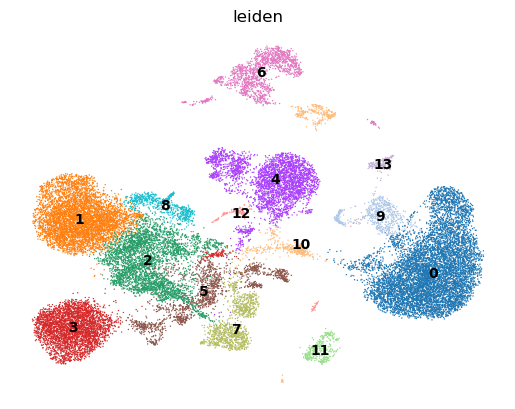

In [6]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")


In [7]:
adata.obs

,library_id,batch,n_genes_by_counts,total_counts,pct_counts_in_top_10_genes,pct_counts_in_top_20_genes,total_counts_MT,pct_counts_MT,total_counts_ribo,pct_counts_ribo,_scvi_batch,_scvi_labels,leiden_scVI,leiden
AAACCAAAGCGTTACA-1-0,5p_GEM_X_10K_PBMC,0,4000,17626.0,12.526949,20.140701,0.0,0.0,0.0,0.0,2,0,2,3
AAACCAAAGGCTGGAA-1-0,5p_GEM_X_10K_PBMC,0,6045,35020.0,9.948601,15.171331,0.0,0.0,0.0,0.0,2,0,4,0
AAACCAAAGGTATCCA-1-0,5p_GEM_X_10K_PBMC,0,3995,17742.0,12.061774,18.791568,0.0,0.0,0.0,0.0,2,0,0,1
AAACCAGCAATAGCAG-1-0,5p_GEM_X_10K_PBMC,0,4132,17379.0,13.148052,19.535071,0.0,0.0,0.0,0.0,2,0,2,3
AAACCCATCAATCTGG-1-0,5p_GEM_X_10K_PBMC,0,3878,14828.0,10.743189,16.118155,0.0,0.0,0.0,0.0,2,0,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGCTATTG-1-3,3p_NextGEM_5K_PBMC,3,2883,8053.0,11.548491,16.701850,0.0,0.0,0.0,0.0,1,0,13,7
TTTGTTGCATATGCGT-1-3,3p_NextGEM_5K_PBMC,3,3034,9464.0,13.736264,20.054945,0.0,0.0,0.0,0.0,1,0,7,6
TTTGTTGCATCCGAAT-1-3,3p_NextGEM_5K_PBMC,3,3656,10766.0,8.740479,12.493034,0.0,0.0,0.0,0.0,1,0,21,12
TTTGTTGCATTGAGGG-1-3,3p_NextGEM_5K_PBMC,3,1755,3553.0,11.849142,16.802702,0.0,0.0,0.0,0.0,1,0,1,0


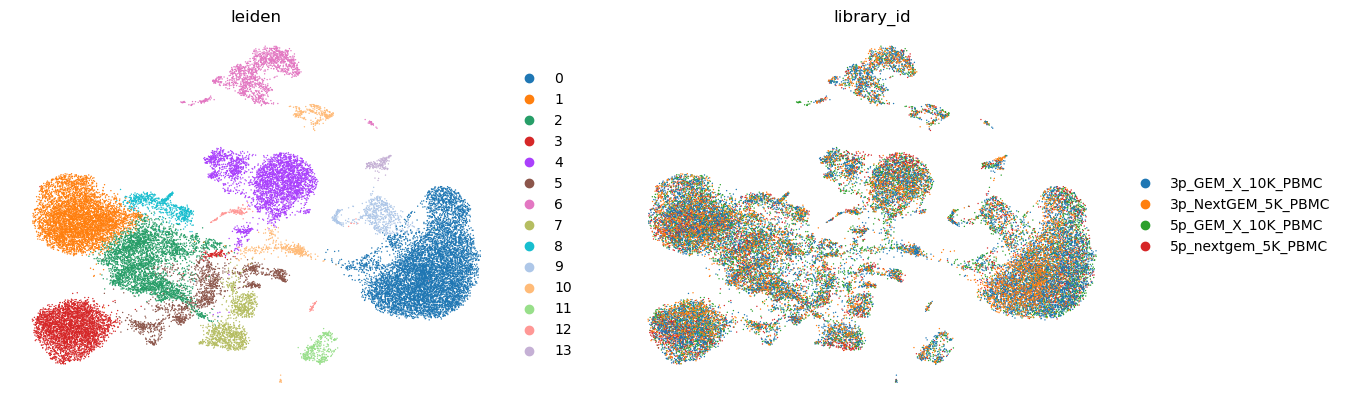

In [8]:
sc.pl.umap(adata, color = ['leiden', 'library_id'], frameon = False)

In [9]:
sc.tl.rank_genes_groups(adata, 'leiden')


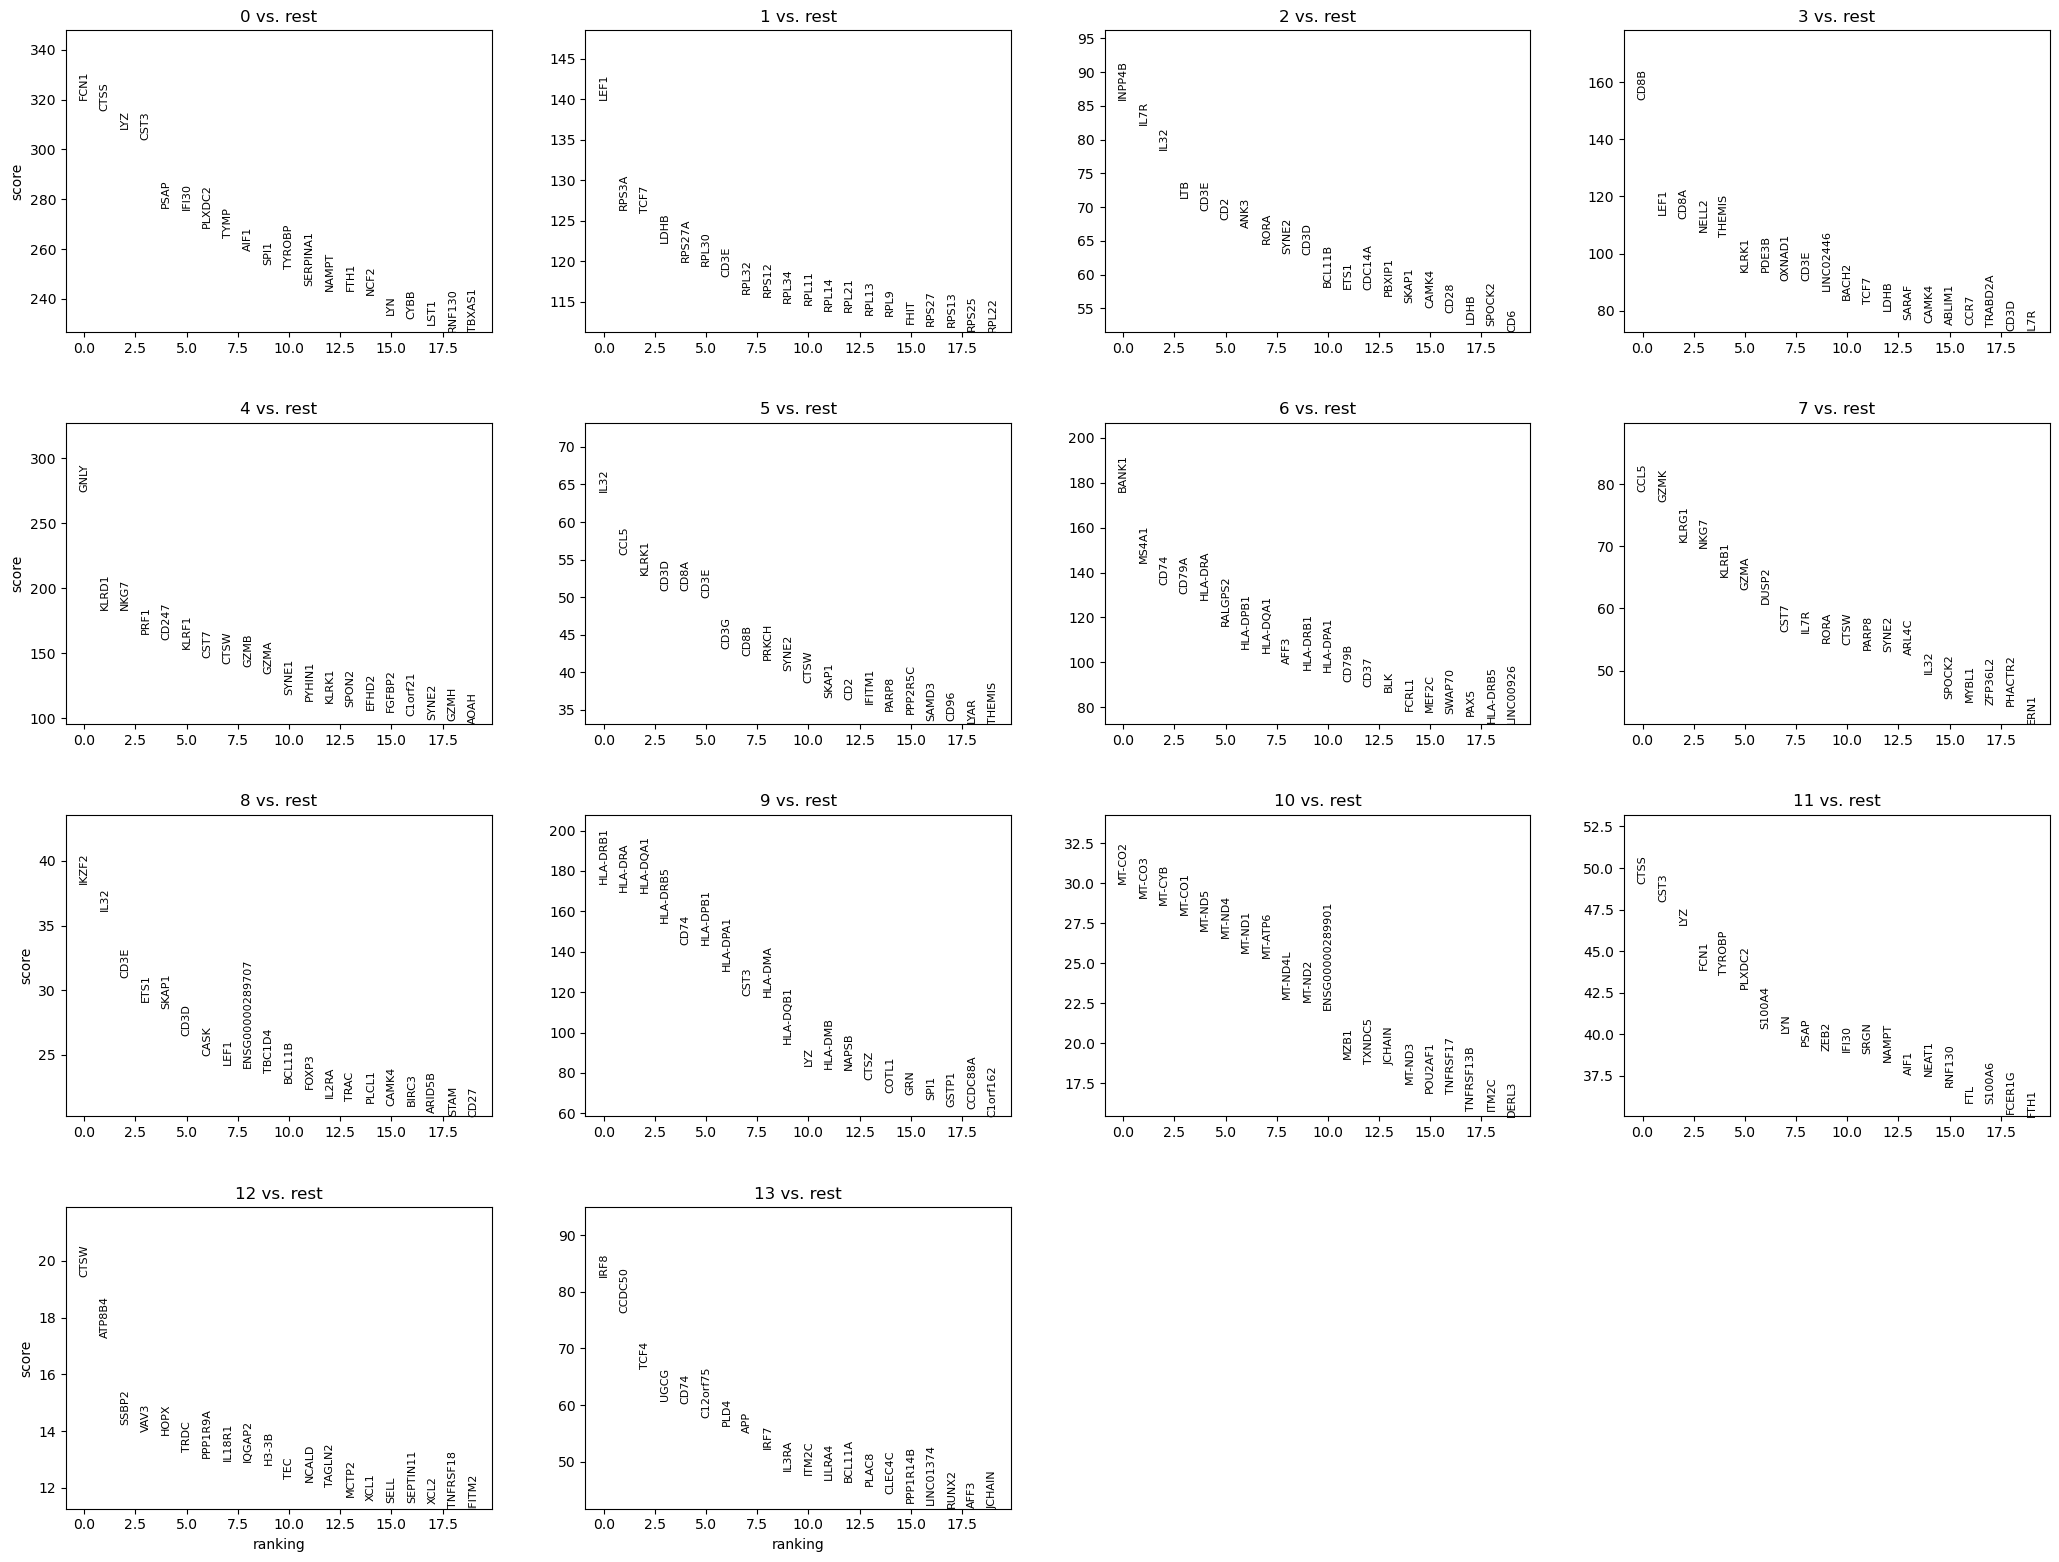

In [10]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [11]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,FCN1,319.828278,6.536319,0.000000e+00,0.000000e+00
1,0,CTSS,315.413574,4.511581,0.000000e+00,0.000000e+00
2,0,LYZ,308.033569,6.817351,0.000000e+00,0.000000e+00
3,0,CST3,303.689636,5.576727,0.000000e+00,0.000000e+00
4,0,PSAP,276.291321,3.989720,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...
540479,13,MCTP2,-62.357403,-5.518909,5.645540e-258,2.157938e-255
540480,13,PLAAT4,-62.808281,-4.653763,1.704228e-142,2.222751e-140
540481,13,LRP1,-66.498222,-6.054286,2.676800e-299,1.396494e-296
540482,13,SAMD3,-68.650146,-5.414332,4.165479e-230,1.286500e-227


In [12]:
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,FCN1,319.828278,6.536319,0.000000,0.000000
1,0,CTSS,315.413574,4.511581,0.000000,0.000000
2,0,LYZ,308.033569,6.817351,0.000000,0.000000
3,0,CST3,303.689636,5.576727,0.000000,0.000000
4,0,PSAP,276.291321,3.989720,0.000000,0.000000
...,...,...,...,...,...,...
506312,13,RINT1,2.332645,0.603069,0.020876,0.048747
506313,13,CCDC194,2.329591,1.990171,0.021048,0.049113
506314,13,PKD1,2.329461,0.657117,0.021046,0.049112
506315,13,ENSG00000289449,2.327922,2.989068,0.021142,0.049319


In [13]:
markers_scvi = vae.differential_expression(groupby = 'leiden')
markers_scvi

DE...: 100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
ZEB1,0.9998,0.0002,8.516943,0.000025,0.003443,0.0,0.25,-7.420837,-7.563085,1.908446,...,0.009879,0.783457,0.023591,0.650402,0.245078,36.139614,True,0 vs Rest,0,Rest
TPD52,0.9992,0.0008,7.130086,0.000020,0.001209,0.0,0.25,-5.856318,-5.804107,1.448168,...,0.007858,0.306719,0.018490,0.327053,0.200732,12.930037,True,0 vs Rest,0,Rest
CD69,0.9984,0.0016,6.436144,0.000124,0.005173,0.0,0.25,-5.367198,-5.533759,1.285810,...,0.051842,1.156207,0.122418,0.792762,1.288608,52.600990,True,0 vs Rest,0,Rest
PCED1B,0.9978,0.0022,6.117091,0.000094,0.003308,0.0,0.25,-5.151641,-5.264587,1.340442,...,0.041592,0.777533,0.075618,0.664046,1.035245,35.829990,True,0 vs Rest,0,Rest
BACH2,0.9976,0.0024,6.029880,0.000064,0.005296,0.0,0.25,-6.253612,-6.550486,2.033206,...,0.026475,1.111651,0.060061,0.680717,0.669463,52.477917,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRGN,0.6590,0.3410,0.658841,0.006226,0.005562,0.0,0.25,0.331988,0.040759,0.832030,...,1.869246,1.617263,0.963415,0.820777,61.193253,55.368900,False,13 vs Rest,13,Rest
MCL1,0.6516,0.3484,0.626080,0.003302,0.003711,0.0,0.25,-0.099001,-0.189099,0.501535,...,1.014482,1.061291,0.902439,0.775258,33.128368,38.037441,False,13 vs Rest,13,Rest
S100A6,0.6430,0.3570,0.588409,0.006448,0.007092,0.0,0.25,-0.020120,-0.150965,0.804332,...,1.906605,1.934655,0.993902,0.907889,63.269863,71.101898,False,13 vs Rest,13,Rest
VIM,0.6250,0.3750,0.510826,0.009123,0.008385,0.0,0.25,0.238604,0.115535,0.727482,...,2.692022,2.147137,0.981707,0.918120,88.523247,82.814835,False,13 vs Rest,13,Rest


In [14]:
markers_scvi = markers_scvi[(markers_scvi['is_de_fdr_0.05']) & (markers_scvi.lfc_mean > .5)]
markers_scvi

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
ENSG00000289039,0.9960,0.0040,5.517450,5.151425e-05,1.550568e-06,0.0,0.25,7.311298,7.436452,2.255024,...,0.018546,0.000319,0.046544,0.001039,0.489584,0.009359,True,0 vs Rest,0,Rest
ENSG00000290441,0.9958,0.0042,5.468460,2.164348e-04,9.484263e-06,0.0,0.25,5.429811,5.479200,1.939177,...,0.082220,0.002278,0.118975,0.004066,2.049043,0.083322,True,0 vs Rest,0,Rest
MAFB,0.9956,0.0044,5.421739,2.701902e-03,7.910904e-05,0.0,0.25,7.098981,7.276307,2.203125,...,0.979272,0.023216,0.808850,0.030948,24.507250,0.759839,True,0 vs Rest,0,Rest
ENSG00000230492,0.9956,0.0044,5.421739,1.499753e-05,7.338547e-07,0.0,0.25,4.909093,4.995031,1.792056,...,0.004976,0.000061,0.012242,0.000181,0.128915,0.001619,True,0 vs Rest,0,Rest
DUSP6,0.9954,0.0046,5.377086,2.694105e-03,1.815456e-04,0.0,0.25,4.671529,4.712594,1.636446,...,0.977760,0.051297,0.807447,0.067859,24.385813,1.816935,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000205041,0.9124,0.0876,2.343297,4.794385e-06,4.605994e-06,0.0,0.25,0.573077,0.611246,2.164214,...,0.001909,0.001301,0.006098,0.002549,0.058491,0.046312,True,13 vs Rest,13,Rest
CYP8B1,0.9124,0.0876,2.343297,3.045671e-06,3.664051e-06,0.0,0.25,0.718294,0.815871,2.041728,...,0.000000,0.000477,0.000000,0.000570,0.000000,0.020625,True,13 vs Rest,13,Rest
RSPO4,0.9120,0.0880,2.338303,1.022475e-05,1.127897e-05,0.0,0.25,0.639812,0.659806,2.041553,...,0.002059,0.002466,0.006098,0.003858,0.067669,0.105757,True,13 vs Rest,13,Rest
ENSG00000254810,0.9112,0.0888,2.328376,9.996468e-07,2.608620e-06,0.0,0.25,1.121957,1.170254,1.510896,...,0.000000,0.000289,0.000000,0.000302,0.000000,0.011286,True,13 vs Rest,13,Rest


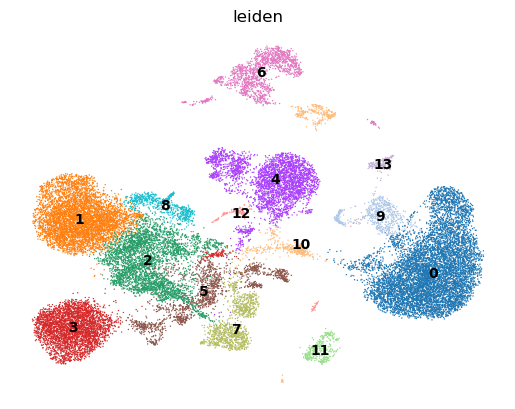

In [15]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

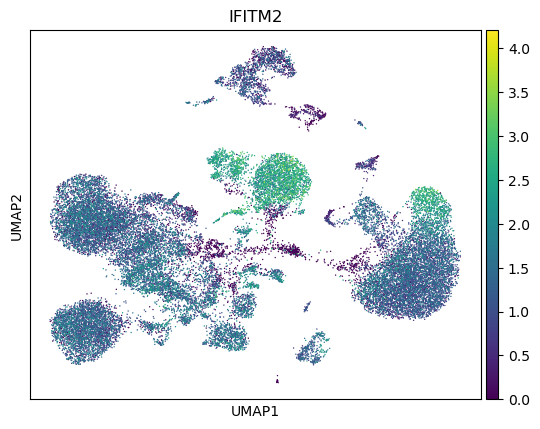

In [56]:
sc.pl.umap(adata, color = ['IFITM2'])
#frameon = False, layer = 'scvi_normalized', vmax = 10)

In [57]:
markers[markers.names == 'IFITM2']

,group,names,scores,logfoldchanges,pvals,pvals_adj
154473,4,IFITM2,69.266068,1.875277,0.000000e+00,0.000000e+00
463291,12,IFITM2,11.265800,1.437217,2.348621e-22,4.792329e-21


In [35]:
markers_scvi[markers_scvi.group1 =='9']

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
P3H2,0.9988,0.0012,6.724225,0.000243,0.000025,0.0,0.25,6.070914,6.126295,2.203814,...,0.082065,0.006514,0.182830,0.008110,2.530272,0.208167,True,9 vs Rest,9,Rest
SPIB,0.9980,0.0020,6.212601,0.000481,0.000250,0.0,0.25,5.045653,5.168221,3.205948,...,0.133884,0.055952,0.282989,0.048693,4.237490,2.073830,True,9 vs Rest,9,Rest
DENND5B,0.9968,0.0032,5.741396,0.000507,0.000186,0.0,0.25,4.506937,4.760910,2.788032,...,0.183131,0.048643,0.372019,0.053191,5.856534,1.858379,True,9 vs Rest,9,Rest
KIT,0.9960,0.0040,5.517450,0.000206,0.000016,0.0,0.25,7.316092,7.467322,3.353171,...,0.071861,0.003736,0.190779,0.004498,2.339286,0.151569,True,9 vs Rest,9,Rest
FCER1A,0.9960,0.0040,5.517450,0.006311,0.000089,0.0,0.25,8.756471,9.007230,3.483302,...,2.031928,0.026154,0.810811,0.026170,62.116238,0.759095,True,9 vs Rest,9,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CACNB4,0.9274,0.0726,2.547420,0.000113,0.000088,0.0,0.25,1.002434,1.148337,2.204577,...,0.049911,0.033248,0.119237,0.044229,1.610247,0.947614,True,9 vs Rest,9,Rest
SVEP1,0.9272,0.0728,2.544453,0.000005,0.000004,0.0,0.25,1.063679,1.036266,2.451447,...,0.001575,0.000846,0.004769,0.001159,0.047725,0.027682,True,9 vs Rest,9,Rest
IGHV1-18,0.9268,0.0732,2.538542,0.000003,0.000037,0.0,0.25,0.563584,0.897938,3.004897,...,0.000000,0.004552,0.000000,0.002113,0.000000,0.174857,True,9 vs Rest,9,Rest
CXXC4-AS1,0.9266,0.0734,2.535598,0.000002,0.000003,0.0,0.25,0.774009,0.950295,2.308429,...,0.001331,0.000661,0.003180,0.001159,0.040394,0.024021,True,9 vs Rest,9,Rest


In [ ]:
#reference used: http://cells.ucsc.edu/?ds=covid19-immuno+all&cell=Severe_P09_CTAAGACCAACTGCGC&gene=LILRA4

In [ ]:
for x in range(0,16):
    print(f'"{x}":"",')
for x in range(0,16):
    print(f'"{x} marker used":"",')

In [ ]:
"0":"CD14+ Monocyte",
"1":"T",
"2":"CD8 T",
"3":"Basophil",
"4":"NK",
"5":"B", maybe b memory 
"6":"B naive"
"7":"CD16+ Monocyte",
"8":"",
"9":"",
"10":"B memories",
"11":"CD8 T",
"12":"",
"13":"DC",
"14":"Plasma",
"15":"Platelet",
"0 marker used":"FCN1",
"1 marker used":"CD3E",
"2 marker used":"CD3E, CD8A",
"3 marker used":"CCL4",
"4 marker used":"'CTSW', 'CST7'",
"5 marker used":"CD79A",
"6 marker used":"'P2RX5', 'PAX5', 'EBF1', 'CD19'",
"7 marker used":"IFITM3",
"8 marker used":"",
"9 marker used":"",
"10 marker used":"'NPIPB15','CD203C'",
"11 marker used":"'CD3E','CD8A'",
"12 marker used":"",
"13 marker used":"LILRA4",
"14 marker used":"MZB1",
"15 marker used":"PPBP",
